### Common Functions ###

In [2]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import auc,roc_curve,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV,cross_validate,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
import pandas as pd
import numpy as np

#some print formatting constants
BOLD_START = '\033[1m'
END = '\033[0m'
UNDERLINE = '\033[4m'
DARKCYAN = '\033[36m'

models = {
    "LR" : LogisticRegression(random_state=123),
    "RF" : RandomForestClassifier(),
    "GB" : GradientBoostingClassifier()
}

params_grid = {

    "LR" : {'model__C' :[x/10 for x in range(1,11)],'model__max_iter' : [10000]},

    "RF" :{'model__n_estimators' : range(50,100,10)},

    "GB" :{'model__n_estimators' : range(50,100,10),'model__learning_rate':[0.1]},
}



def evaluate_performance(model_key,X_train,y_train,X_test,cv=5, model_name=None):

    print('%s%s%s%s%s' %(BOLD_START,UNDERLINE,DARKCYAN,'Evaluating performance for {}'.format(model_name),END))
    gs_result = grid_search_cv(model_key,X_train,y_train,cv=5)
    estimator = gs_result.best_estimator_
    score = cross_val_score(estimator,X_train,y_train,cv=cv)
    cv_results = cross_validate(estimator,X_train,y_train,cv=cv,scoring=['accuracy','recall','roc_auc','precision_macro','recall_macro'])
    cl_report = classification_report(y_test,estimator.predict(X_test))
    print('%s%s%s'%(BOLD_START,'Classification Report\n',END))
    accuracy = accuracy_score(y_test,estimator.predict(X_test))
    roc_auc  = roc_auc_score(y_test,estimator.predict(X_test))
    print('%s%s%s'%(BOLD_START,'Accuracy amd roc_auc scores\n',END))
    print('accuracy = %0.4f, roc_auc = %0.4f'%(accuracy,roc_auc))
    plot_classification_report(estimator,X_test,y_test,model_name=model_name)

def plot_classification_report(estimator,X_test,y_test,model_name=None):
    precision_1 = precision_score(y_test,estimator.predict(X_test))
    recall_1 = recall_score(y_test,estimator.predict(X_test))
    f1_1 = f1_score(y_test,estimator.predict(X_test))

    precision_0 = precision_score(y_test,estimator.predict(X_test),pos_label=0)
    recall_0 = recall_score(y_test,estimator.predict(X_test),pos_label=0)
    f1_0 = f1_score(y_test,estimator.predict(X_test),pos_label=0)

    cl_report_dict = {
        'left' : [0,1],
        'precision':[precision_0,precision_1],
        'recall':[recall_0,recall_1],
        'f1':[f1_0,f1_1]
    }

    df = pd.DataFrame(cl_report_dict)
    sns.heatmap(df,annot=True,cmap='GnBu')
    plt.xlabel('Metrics')
    plt.ylabel('Classes')
    plt.suptitle('Classification report for {}'.format(model_name))
    plt.show()


def grid_search_cv(model_key,X_train,y_train,cv=5):
    model = models[model_key]
    param_grid = params_grid[model_key]
    pipeline = Pipeline([('scaler', StandardScaler()), ('model', model)])
    grid_search = GridSearchCV(pipeline,param_grid,scoring='accuracy',cv=cv)
    grid_search.fit(X_train,y_train)
    print('%s%s%s'%(BOLD_START,'Best scores and Best Params\n',END))
    print('best score = {}'.format(grid_search.best_score_))
    print('best params = {}'.format(grid_search.best_params_))
    return grid_search

def plot_roc_curve_and_cm(pipeline,X_test,y_test,model_name=None):
    print('%s%s%s%s'%(BOLD_START,DARKCYAN,'evaluating and visualizing ROC_AUC curve and Confusion Matrix for {}\n'.format(model_name),END))
    y_pred_test = pipeline.predict(X_test)
    y_pred_test_prob = pipeline.predict_proba(X_test)
    # plot confusion matrix
    print('Plotting confusion matrix\n')
    cm = confusion_matrix(y_test,y_pred_test)
    print('confusion matrix\n',cm)
    display_labels = ['stayed','left']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot()
    plt.suptitle('Confusion Matrix for {}'.format(model_name))
    plt.show()

    # plot ROC_AUC curve
    print('Plotting ROC_AUC curve\n')
    # we need the probability of 1s which is the second column(index 1)
    y_positive_probability = y_pred_test_prob[:,1]
    result_df = pd.DataFrame({'Actual_label': y_test, 'Pred_label': y_pred_test, 'Pred_prob': y_positive_probability})
    fpr,tpr,threshold = roc_curve(y_test, y_positive_probability)
    area_under_curve = auc(fpr,tpr)
    print('auc = {}\n'.format(area_under_curve))
    plt.plot(fpr,tpr,label=f'ROC curve , AUC = {area_under_curve:.4f}')
    plt.plot([0,1],[0,1],linestyle='--',color='gray')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    title_ = 'ROC curve for various thresholds for {}'.format(model_name)
    plt.title(title_)
    plt.legend(loc = 'lower right')
    plt.show()

def create_pipeline(model,X_train,y_train):
     pipeline = Pipeline([('scaler', StandardScaler()), ('model', model)])
     pipeline.fit(X_train,y_train)
     return pipeline







### EDA ###

In [3]:
import pandas as pd

print('%s%s%s%s%s' %(BOLD_START,UNDERLINE,DARKCYAN,'Exploratory Data Analysis',END))
# this is the same data as provided in the assignment which i have committed to github.
#This way it is possible to run from anywhere when the file is not present locally
url = 'https://raw.githubusercontent.com/tksundar/employee_turnover/refs/heads/master/HR_comma_sep.csv'

hr_data = pd.read_csv(url,header=0,skip_blank_lines=True, skipinitialspace=True)
#check for missing values
if hr_data.isna().sum().any():
    print('missing values found')
else:
    print('no missing values found')

#the column sales has to be renamed to dept
hr_data.rename(columns = {'sales':'dept'},inplace = True)
# we willl also fix a typo in the column name
hr_data.rename(columns = {'average_montly_hours':'average_monthly_hours'},inplace = True)


Exploratory Data Analysis
no missing values found


2.	Understand what factors contributed most to employee turnover at EDA.<br>
    2.1.	Draw a heatmap of the correlation matrix between all numerical features or columns in the data.<br>
    2.2.	Draw the distribution plot of:<br>
      *   Employee Satisfaction (use column satisfaction_level)
      *   Employee Evaluation (use column last_evaluation)
      *   Employee Average Monthly Hours (use column average_montly_hours)<p>
    2.3.	Draw the bar plot of the employee project count of both employees who left and stayed in the organization (use column number_project and hue column left), and give your inferences from the plot.


**Heatmap**

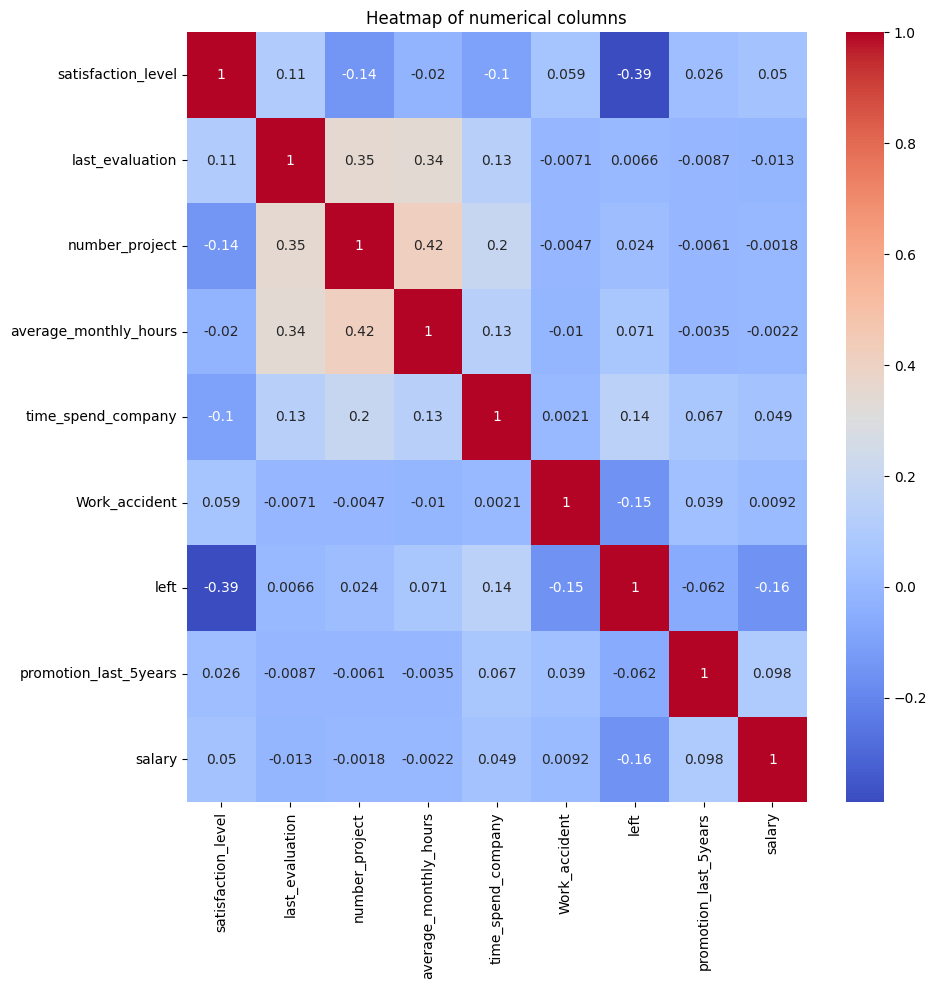

In [4]:
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
#encode the salary data
categories = hr_data['salary'].unique()
enc = OrdinalEncoder(categories=[categories])
hr_data['salary'] = enc.fit_transform(pd.DataFrame(hr_data['salary']))
hr_data.drop(['dept'],axis=1)
plt.figure(figsize=(10,10))
sns.heatmap(hr_data.corr(numeric_only=True),annot=True,cmap='coolwarm')
plt.title('Heatmap of numerical columns')
plt.show()

We can see that average_monthly_hours,number_project and last_evaluation has medium positive correlation among themselves.Employee turnover has a medium correlation with satisfaction_level. Most probably, these three or four features could predict future employee turn over.

**Histograms**

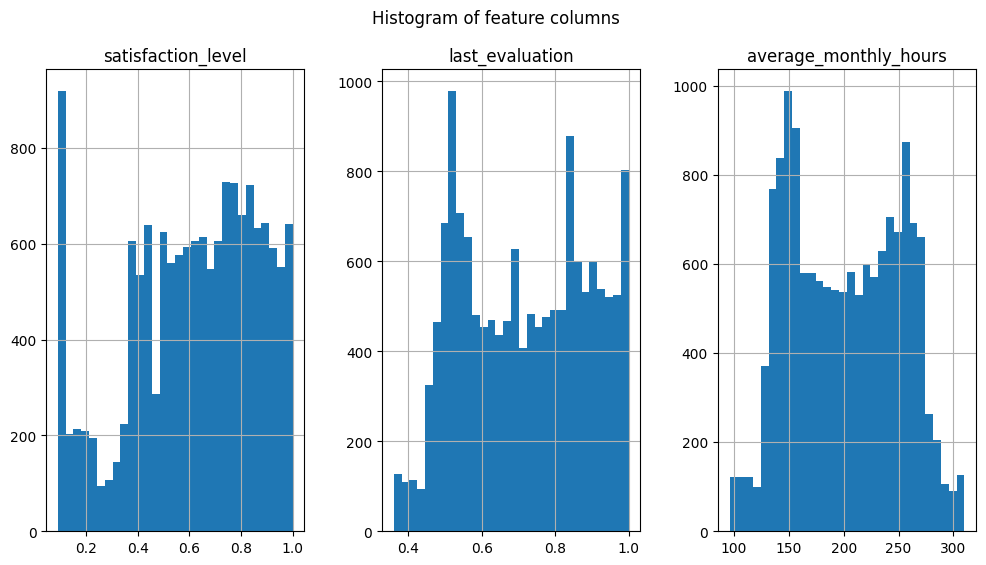

In [5]:
hr_data.drop(['left'],axis=1).loc[:,['satisfaction_level','last_evaluation','average_monthly_hours']].hist(bins=30,figsize = (12,6),layout=(1,3))
plt.suptitle('Histogram of feature columns')
plt.show()

**Bar Plot**

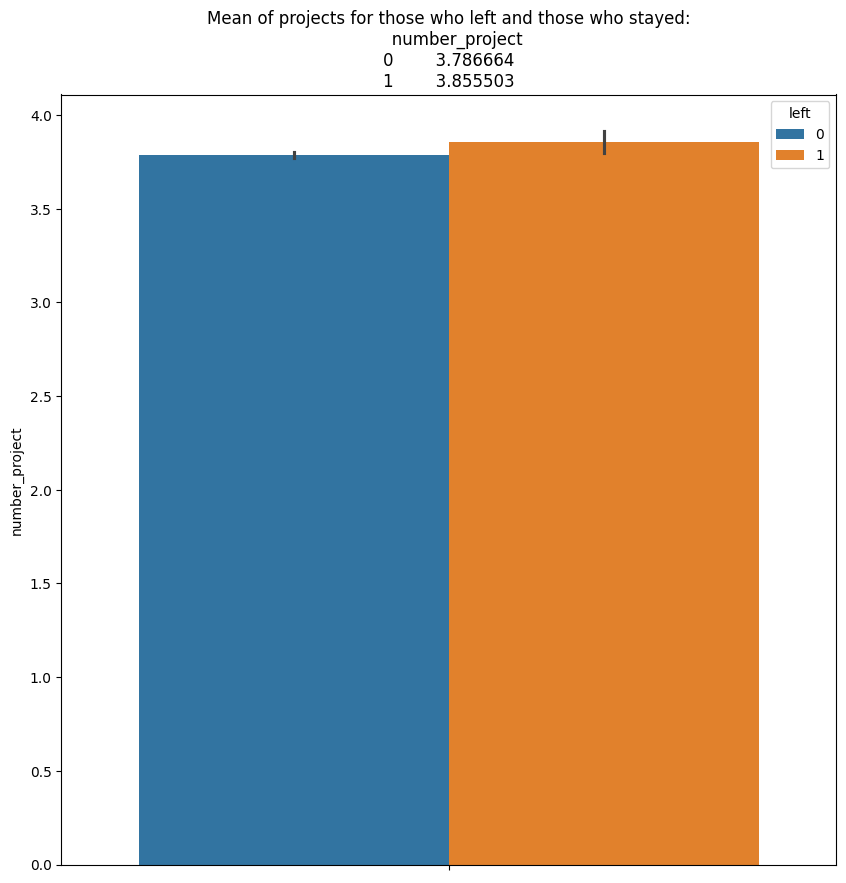

In [6]:
plt.figure(figsize=(10,10))
sns.barplot(y=hr_data['number_project'],data=hr_data,hue = 'left')
plt.title('Mean of projects for those who left and those who stayed:\n{}'.format(pd.DataFrame(hr_data.groupby('left').number_project.mean()).reset_index(drop=True)))
plt.show()

## Inference: ##

The bar graph above shows that those who stayed and those who left did roughly the same number of projects. So this could not be the reason for an employee leaving


### 3.	Perform clustering of employees who left based on their satisfaction and evaluation.###
* 3.1 Choose columns satisfaction_level, last_evaluation, and left.
* 3.2 Do K-means clustering of employees who left the company into 3 clusters?
* 3.3 Based on the satisfaction and evaluation factors, give your thoughts on  
  the employee clusters.


**Initial Scatter plot**

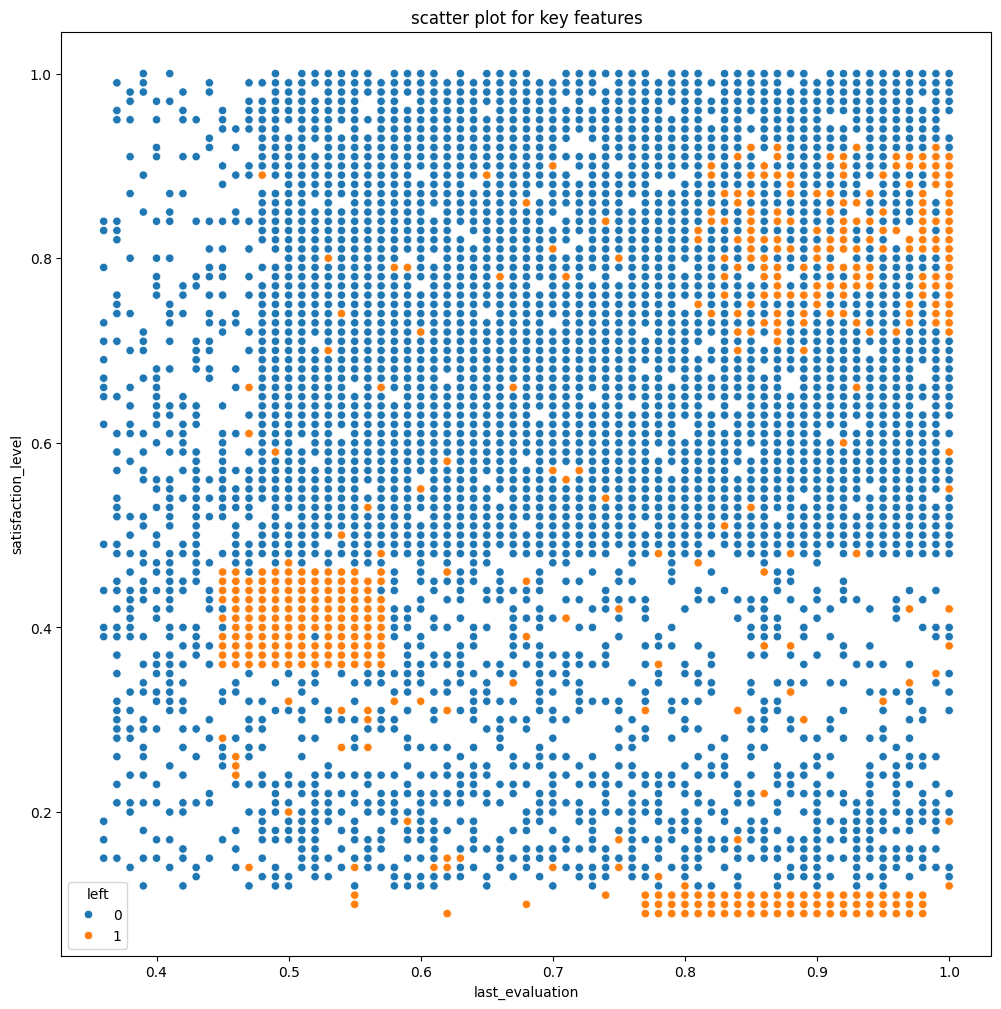

In [7]:
plt.figure(figsize=(12,12))
sns.scatterplot(data=hr_data,x='last_evaluation',y='satisfaction_level',hue='left')
plt.title('scatter plot for key features')
plt.show()



Looking at the above plot,we see employees leaving for a wide range of satisfaction_level and last_evaluation. However we can also see 3 concentrated regions of employee leaving, but it is not obviuos how many clusters will be optimun for k means clustering. So we will use the elbow curve to find out

**Elbow Curve**

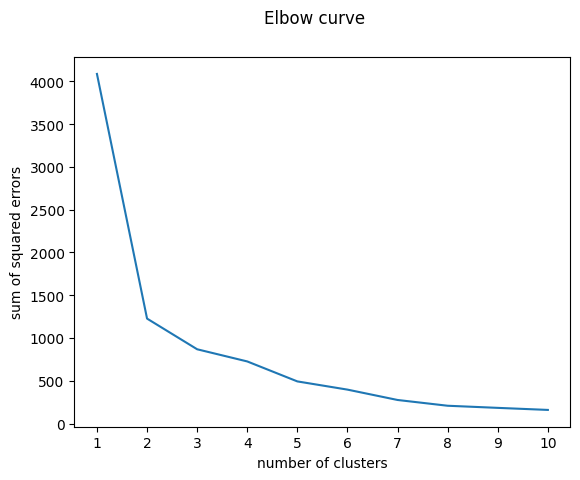

In [ ]:
from sklearn.cluster import KMeans

df = hr_data.loc[:,['satisfaction_level','last_evaluation','left']]
sum_squared_errors = []

for k in range(1,11):
  km = KMeans(n_clusters=k)
  km.fit(df)
  sum_squared_errors.append(km.inertia_)
plt.plot(range(1,11),sum_squared_errors)
plt.xticks(range(1,11))
plt.xlabel('number of clusters')
plt.ylabel('sum of squared errors')
plt.suptitle('Elbow curve')
plt.show()



The above elbow curve shows that 2,3,4 and 5 are potential values for n_cluster at which pints there slope of the elbow curve changes.

**Cluster Analysis by cluster numbers**

         satisfaction_level  last_evaluation  left
cluster                                           
0                  0.666810         0.715473   0.0
1                  0.440098         0.718113   1.0
         satisfaction_level  last_evaluation  left
cluster                                           
0                  0.666810         0.715473   0.0
1                  0.300270         0.645915   1.0
2                  0.809266         0.908726   1.0
         satisfaction_level  last_evaluation  left
cluster                                           
0                  0.814034         0.738861   0.0
1                  0.300270         0.645915   1.0
2                  0.809266         0.908726   1.0
3                  0.458856         0.682438   0.0
         satisfaction_level  last_evaluation  left
cluster                                           
0                  0.814034         0.738861   0.0
1                  0.458856         0.682438   0.0
2                  0.408687    

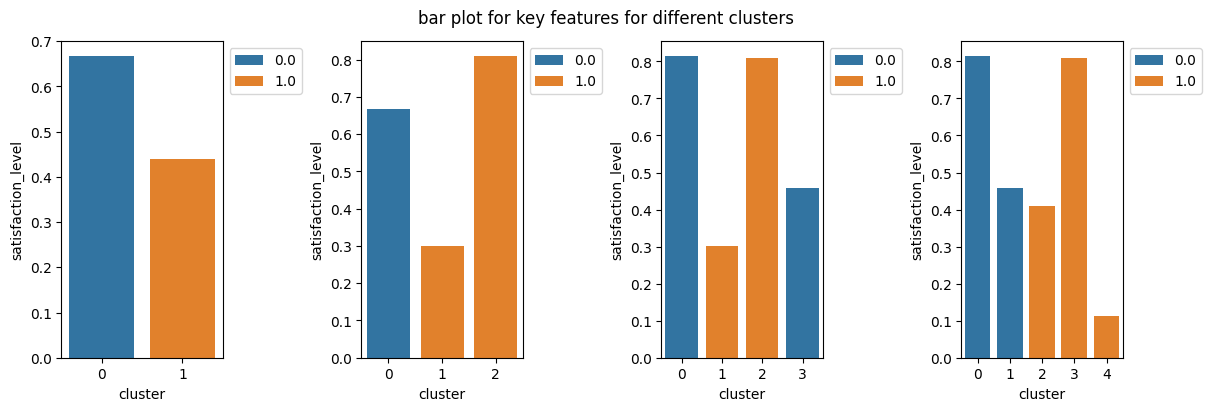

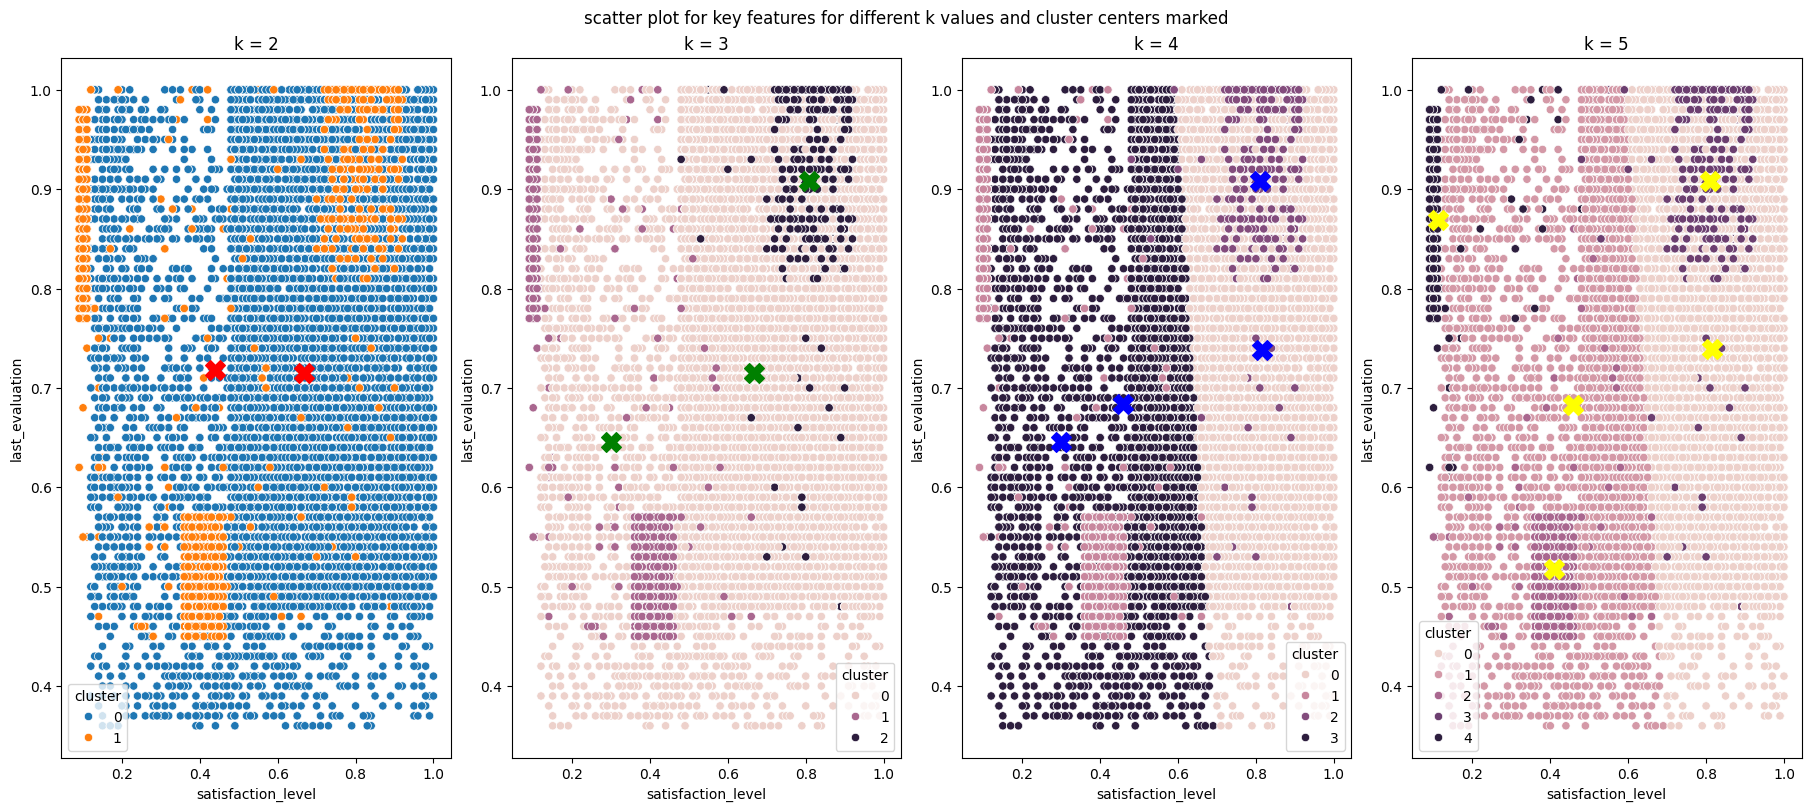

In [ ]:

df = hr_data.loc[:,['satisfaction_level','last_evaluation','left']]
k_values = [2,3,4,5]

fig,axes = plt.subplots(1,len(k_values),figsize=(12,4),layout='constrained')
for i,k in enumerate(k_values):
  km = KMeans(n_clusters=k,random_state=42)
  km.fit(df)
  df['cluster'] = km.predict(df)
  df_cluster_wise = df.groupby('cluster').mean()
  print(df_cluster_wise)
  bars = sns.barplot(data = df_cluster_wise,x='cluster',y='satisfaction_level',hue='left',ax=axes[i])
  bars.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.suptitle('bar plot for key features for different clusters')
plt.show()
print()

fig,axes = plt.subplots(1,len(k_values),figsize=(18,8),layout='constrained')
colors = ['red','green','blue','yellow']
for i,k in enumerate(k_values):
  km = KMeans(n_clusters=k,random_state=42)
  km.fit(df)
  df['cluster'] = km.predict(df)
  cluster_centers = km.cluster_centers_
  axe = sns.scatterplot(data=df,x='satisfaction_level',y='last_evaluation',hue='cluster',ax=axes[i] )
  axe.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='X',s=200,c=colors[i])
  axe.set_title(f'k = {k}')
plt.suptitle('scatter plot for key features for different k values and cluster centers marked')
plt.show()


K=5 accurately captures the 3 dense clusters of employee leaving in additon to 2 sparse clusters. At all k values we can see that those with a satisfaction_level around 0.5 or less have left. However with 5 clusters, we can also see that a high satisfaction_level and no recent evaluation( high last_evaluation) have also tended to leave. Those who stayed appear to be those whose satisfaction level was average and whose last_evaluation was also neither too old nor too recent.

<i>The random_state parameter of the <code>KMeans.__init__() </code>method determines the output to a large extent. So the above clustering may not be the same for a differnet random_state</i>





**4.	Handle the left Class Imbalance using the SMOTE technique**




<class 'pandas.core.frame.DataFrame'>
   left  count
0     0  11428
1     1   3571


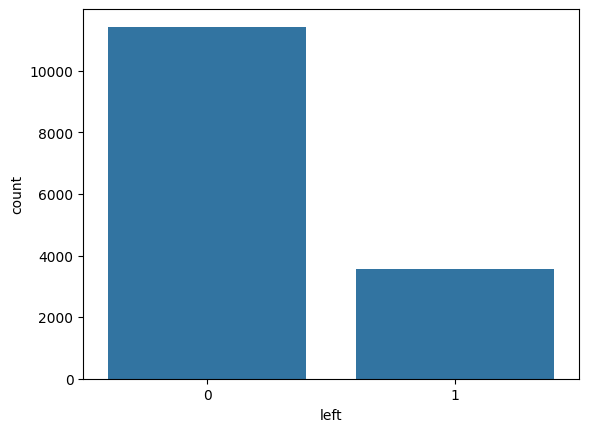

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
class_values = pd.DataFrame(hr_data.value_counts('left')).reset_index()
print(type(class_values))
print(class_values)
sns.barplot(data=class_values,x='left',y='count')
plt.show()

#### Data is  unbalanced and biased towards the minority class(retention or 0 outcomes).  ####

**4.1.	Pre-process the data by converting categorical columns to numerical columns by:**
  * Separating categorical variables and numeric variables
  * Applying get_dummies() to the categorical variables
  * Combining categorical variables and numeric variables







In [ ]:
# we can do all of the above in one line of code as the dataset contains just
# one categorical column, viz., dept. We have already encoded the salary column
# values(low, medium,high)with OrdinalEncoder when generating heatmaps

hr_data = pd.get_dummies(hr_data,dtype=int)
print(hr_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_monthly_hours  14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   salary                 14999 non-null  float64
 9   dept_IT                14999 non-null  int64  
 10  dept_RandD             14999 non-null  int64  
 11  dept_accounting        14999 non-null  int64  
 12  dept_hr                14999 non-null  int64  
 13  dept_management        14999 non-null  int64  
 14  dept_marketing         14999 non-null  int64  
 15  de

#### SMOTE resampling ####

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

sm = SMOTE(random_state=123)
X = hr_data.drop('left',axis=1)
y = hr_data['left']
print(hr_data.shape)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=123) # 80/20 split

print("Before OverSampling, counts of label '1' in train data: {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': in train data {}".format(sum(y_train == 0)))
X_train,y_train = sm.fit_resample(X_train,y_train)

print("After OverSampling, counts of label '1' in train data: {}".format(sum(y_train == 1)))
print("After OverSampling, counts of label '0': in train data {}".format(sum(y_train == 0)))



(14999, 19)
Before OverSampling, counts of label '1' in train data: 2862
Before OverSampling, counts of label '0': in train data 9137
After OverSampling, counts of label '1' in train data: 9137
After OverSampling, counts of label '0': in train data 9137


SMOTE analysis has increased the minority class training sample size to the same as that of the majority class.

**5.Perform 5-fold cross-validation model training and evaluate performance**.

* 5.1.	Train a logistic regression model, apply a 5-fold CV, and plot the classification report.
* 5.2.	Train a Random Forest Classifier model, apply the 5-fold CV, and plot the classification report.
* 5.3.	Train a Gradient Boosting Classifier model, apply the 5-fold CV, and plot the classification report.









Evaluating performance for Logistic Regression
Best scores and Best Params

best score = 0.7969256411465949
best params = {'model__C': 0.1, 'model__max_iter': 10000}
Classification Report

Accuracy amd roc_auc scores

accuracy = 0.7667, roc_auc = 0.7464


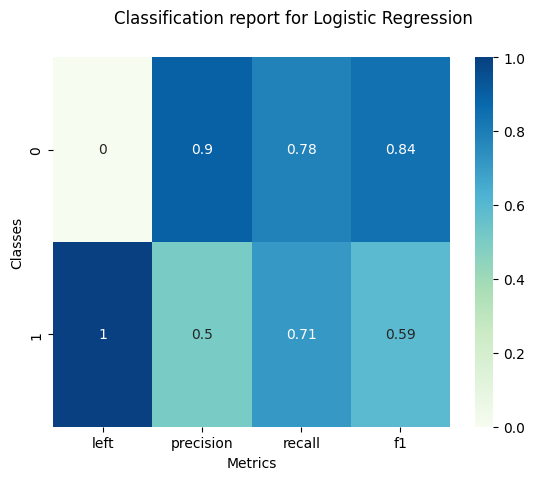

Evaluating performance for Random Forest Classifier
Best scores and Best Params

best score = 0.9835285432002259
best params = {'model__n_estimators': 80}
Classification Report

Accuracy amd roc_auc scores

accuracy = 0.9897, roc_auc = 0.9864


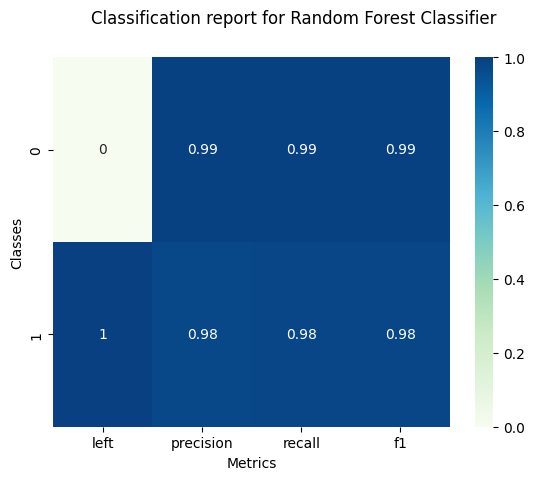

Evaluating performance for Gradient Boosting Classifier
Best scores and Best Params

best score = 0.9618585033585741
best params = {'model__learning_rate': 0.1, 'model__n_estimators': 90}
Classification Report

Accuracy amd roc_auc scores

accuracy = 0.9667, roc_auc = 0.9567


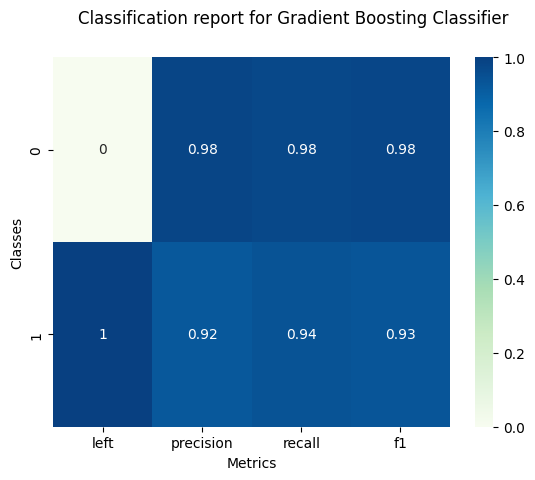

In [ ]:

evaluate_performance('LR',X_train,y_train,X_test,model_name='Logistic Regression')
evaluate_performance('RF',X_train,y_train,X_test,model_name='Random Forest Classifier')
evaluate_performance('GB',X_train,y_train,X_test,model_name='Gradient Boosting Classifier')

The above output show that the Random Forest Classifier performs best with respect to all the metrics.





6.	Identify the best model and justify the evaluation metrics used.
   *    6.1.	Find the ROC/AUC for each model and plot the ROC curve.
   *    6.2.	Find the confusion matrix for each of the models.
   *    6.3.	Explain which metric needs to be used from the confusion matrix: Recall or Precision

Best scores and Best Params

best score = 0.7969256411465949
best params = {'model__C': 0.1, 'model__max_iter': 10000}
evaluating and visualizing ROC_AUC curve and Confusion Matrix for Logistic Regression

Plotting confusion matrix

confusion matrix
 [[1798  493]
 [ 207  502]]


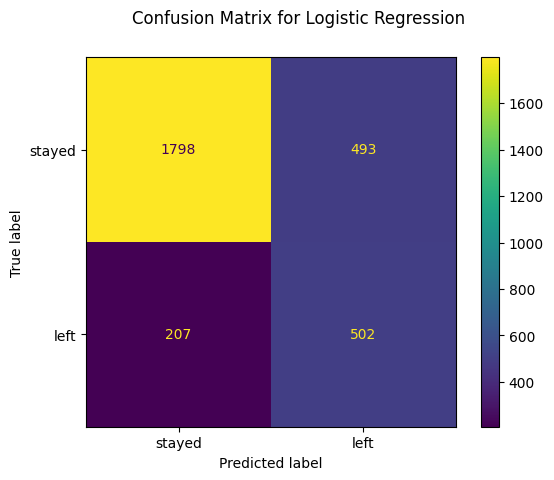

Plotting ROC_AUC curve

auc = 0.8165255716395611



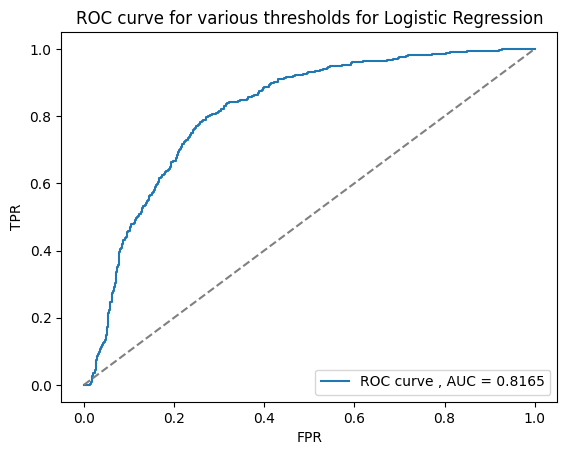

Best scores and Best Params

best score = 0.9833644743649932
best params = {'model__n_estimators': 80}
evaluating and visualizing ROC_AUC curve and Confusion Matrix for Random Forest Classifier

Plotting confusion matrix

confusion matrix
 [[2277   14]
 [  16  693]]


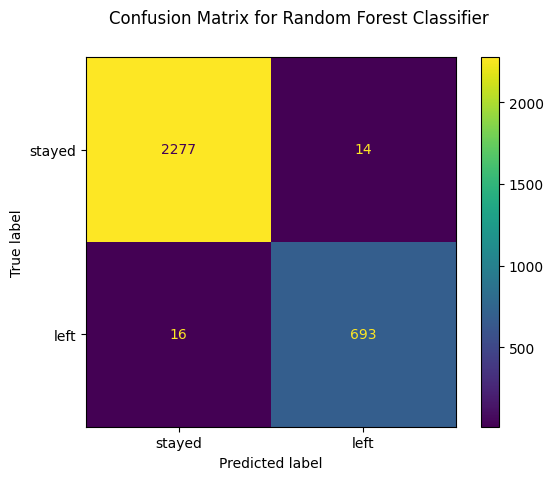

Plotting ROC_AUC curve

auc = 0.9962599711017355



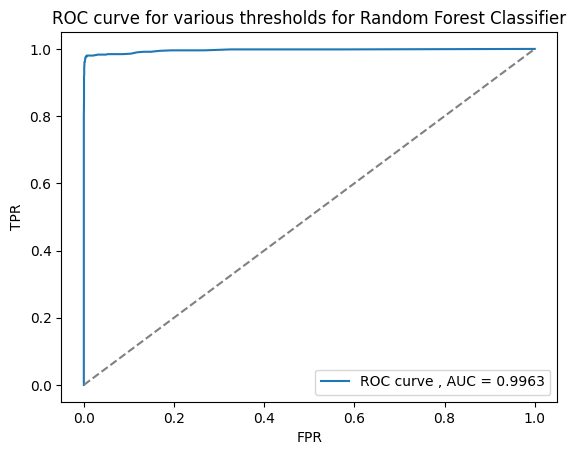

Best scores and Best Params

best score = 0.9618585033585741
best params = {'model__learning_rate': 0.1, 'model__n_estimators': 90}
evaluating and visualizing ROC_AUC curve and Confusion Matrix for Gradient Boosting Classifier

Plotting confusion matrix

confusion matrix
 [[2235   56]
 [  44  665]]


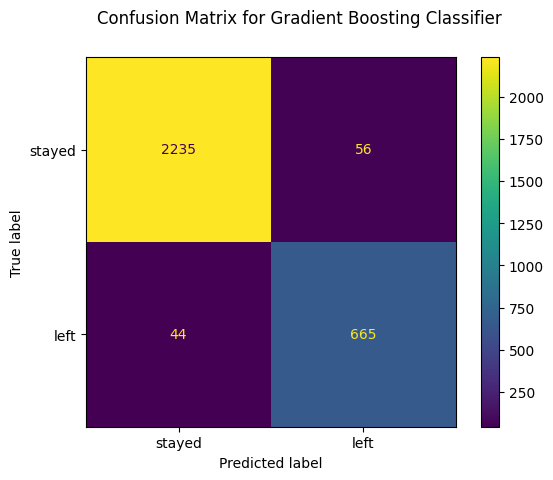

Plotting ROC_AUC curve

auc = 0.9885638227466402



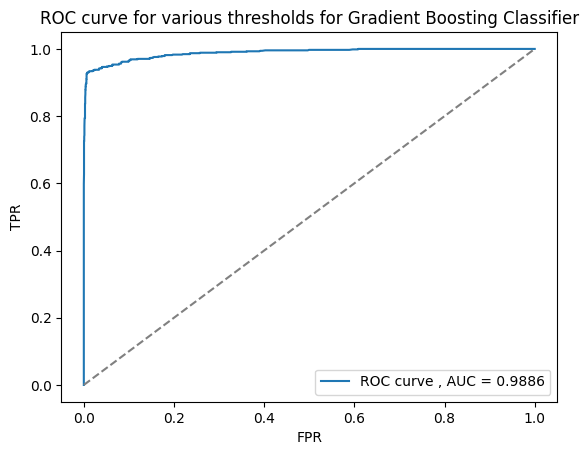

In [ ]:
gs = grid_search_cv('LR',X_train,y_train)
lr_estimator = gs.best_estimator_
pipeline = create_pipeline(lr_estimator,X_train,y_train)
plot_roc_curve_and_cm(pipeline,X_test,y_test,model_name='Logistic Regression')

gs = grid_search_cv('RF',X_train,y_train)
rf_estimator = gs.best_estimator_
pipeline = create_pipeline(rf_estimator,X_train,y_train)
plot_roc_curve_and_cm(pipeline,X_test,y_test,model_name='Random Forest Classifier')

gs = grid_search_cv('GB',X_train,y_train)
gb_estimator = gs.best_estimator_
pipeline = create_pipeline(gb_estimator,X_train,y_train)
plot_roc_curve_and_cm(pipeline,X_test,y_test,model_name='Gradient Boosting Classifier')

Confusion matrix gives the  counts of the following

True Negative , False Positive <br>
False Negative, True Positive <br>

For balanced predicted classes, the accuracy gives a good indication of model performance [ Accuracy = TP+TN/TP+FN+TN+FP )<p>

For inbalanced classes both precison(TP/TP+FP) and recall(TP/TP+FN) are important metrics. The f1 score gives a better metrics of the performance in such cases which is the harmonic mean of precision and recall<p>

f1 score = [ 2(precision x recall/precision+recall) ]

7. Suggest various retention strategies for targeted employees.

    7.1.	Using the best model, predict the probability of employee turnover in the test data.<p>
    7.2.	Based on the probability score range below, categorize the employees into four zones and suggest your thoughts on the retention strategies for each zone.

    * Safe Zone (Green) (Score < 20%)
    * Low-Risk Zone (Yellow) (20% < Score < 60%)
    * Medium-Risk Zone (Orange) (60% < Score < 90%)
    * High-Risk Zone (Red) (Score > 90%).





In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

sm = SMOTE(random_state=123)
X = hr_data.drop('left',axis=1)
y = hr_data['left']
print(hr_data.shape)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=123) # 80/20 split
X_train,y_train = sm.fit_resample(X_train,y_train)
pipeline = create_pipeline(rf_estimator,X_train,y_train)
y_pred_test = pipeline.predict(X_test)
y_pred_test_prob = pipeline.predict_proba(X_test)
y_positive_probability = y_pred_test_prob[:,1]
X_test['pos_probability'] = y_positive_probability
X_test['zones'] = pd.cut(X_test['pos_probability'],bins=[0.0,0.2,0.6,0.9,1],labels=['Safe Zone','Low-Risk Zone','Medium-Risk Zone','High-Risk Zone'])
#The above code puts 0 probablity as NaN. We will change it to safe zone
X_test = X_test.apply(lambda x:x.fillna('Safe Zone'))
X_test.head()
# key_features_df = X_test[['satisfaction_level','last_evaluation','number_project','average_monthly_hours','zones']]
# key_features_df.head()
# key_features_df['zones'].value_counts()
# grp = key_features_df.groupby('zones',observed=False).mean()
# y = ['satisfaction_level','last_evaluation','number_project','average_monthly_hours']
# fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(16,5),layout='constrained')
# for i,y_axis in enumerate(y):
#   bars = sns.barplot(data=grp,x='zones',y=y_axis,ax=axes[i])
#   xticks = bars.get_xticklabels()
#   bars.set_xticks(bars.get_xticks())
#   bars.set_xticklabels(xticks, rotation=90)
# plt.suptitle('Mean of key features for each zone')
# plt.show()


(14999, 19)


,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,dept_IT,dept_RandD,dept_accounting,dept_hr,dept_management,dept_marketing,dept_product_mng,dept_sales,dept_support,dept_technical,pos_probability,zones
6958,0.54,0.67,3,154,2,0,0,2.0,0,0,0,0,0,0,0,1,0,0,0.000,Safe Zone
7534,0.72,0.52,3,143,4,1,0,0.0,0,0,0,0,0,0,0,0,1,0,0.025,Safe Zone
2975,0.95,0.61,3,267,2,0,0,0.0,0,1,0,0,0,0,0,0,0,0,0.025,Safe Zone
3903,0.78,0.79,3,203,2,0,0,0.0,0,0,0,0,0,0,0,1,0,0,0.175,Safe Zone
8437,0.60,0.40,3,146,4,1,0,0.0,0,0,0,0,0,0,0,0,0,1,0.000,Safe Zone


In [ ]:
key_features_df = X_test[['satisfaction_level','last_evaluation','number_project','average_monthly_hours','zones']]
key_features_df.head()
key_features_df['zones'].value_counts()
grp = key_features_df.groupby('zones',observed=False).mean()
grp

,satisfaction_level,last_evaluation,number_project,average_monthly_hours
zones,,,,
Safe Zone,0.670779,0.716935,3.792029,197.205680
Low-Risk Zone,0.463197,0.775082,4.098361,214.483607
Medium-Risk Zone,0.603958,0.785000,4.166667,224.416667
High-Risk Zone,0.439691,0.714977,3.792890,207.194745


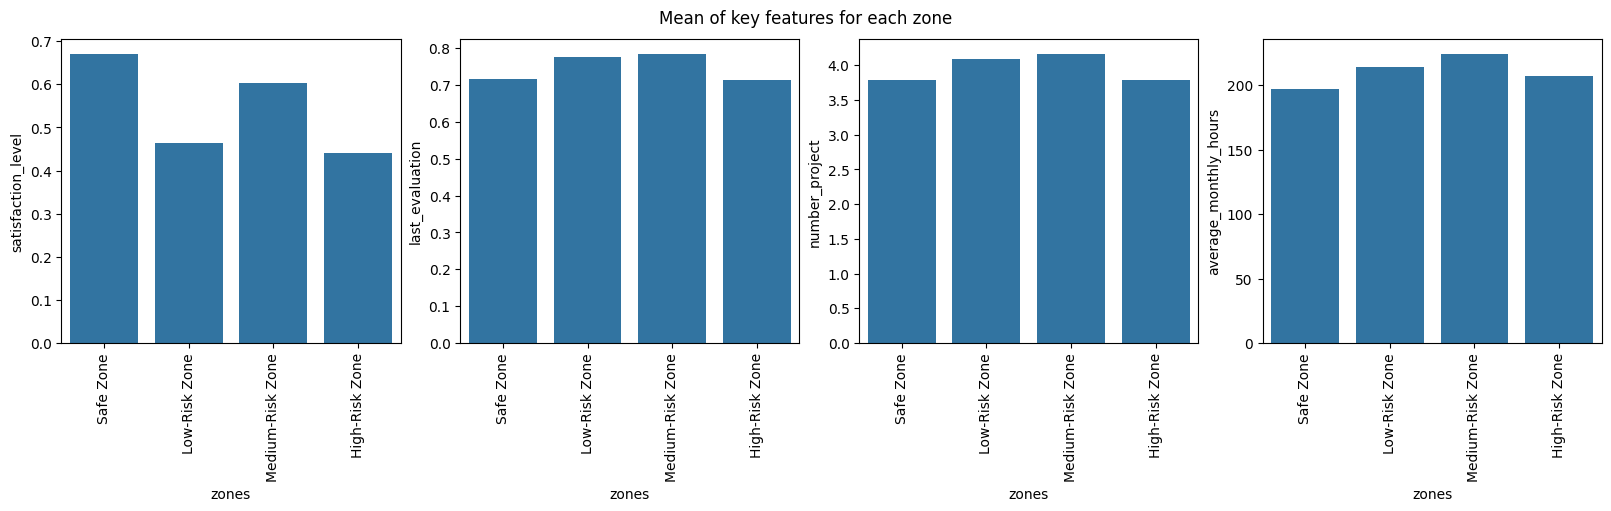

In [ ]:
y = ['satisfaction_level','last_evaluation','number_project','average_monthly_hours']
fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(16,5),layout='constrained')
for i,y_axis in enumerate(y):
  bars = sns.barplot(data=grp,x='zones',y=y_axis,ax=axes[i])
  xticks = bars.get_xticklabels()
  bars.set_xticks(bars.get_xticks())
  bars.set_xticklabels(xticks, rotation=90)
plt.suptitle('Mean of key features for each zone')
plt.show()

### Recommendation based on the above data: ###

Safe Zone : Have the highest satisfaction rate and relatively most recent last evaluation. They share about the same number of projects and average monthly hours.

Low risk Zone: Have low satisfaction_level , but are being managed by more frequent evaluations. The other factors seem to be non-contributing

Medium risk zone: They have better satisfaction level than low and high risk categories, but they seem to have the the highest intervel since last evaluation. They also seem to be spending the maximum time at office.

High risk zone : These have the least satisfaction level , and do badly in all other metrics.

#### Suggestions for retention ####
<code><i>To increase retention , the company should aim to increase the satisfaction level. From the data, it appears that reducing working hours and having more frequent evaluations can manage the risk effectively</i></code>